In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
# Logsumexp function
from scipy.misc import logsumexp
# gaussian pdf
from scipy.stats import multivariate_normal

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5e
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 30
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

In [3]:
# Show the current print options
np.get_printoptions()

{'edgeitems': 3,
 'formatter': None,
 'infstr': 'inf',
 'linewidth': 75,
 'nanstr': 'nan',
 'precision': 8,
 'suppress': False,
 'threshold': 1000}

In [4]:
np.set_printoptions(precision = 5)

# Tools

In [82]:
from tools.graphics import as_si, make_grid, plot_data, plot_frontiere, plot_cov_ellipse, init_plotting
from tools.mixture import K_means, GM
from tools.hmm import HMM

# Constants

In [6]:
DATA_DIR = "data/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

## Reading data

In [7]:
D = {}
for t in ["data", "test"]:
    D[t] = pd.read_csv(DATA_DIR + "EMGaussian" + "." + t, sep = ' ', names = ["x1", "x2"])
u_train = D["data"].as_matrix()
u_test = D["test"].as_matrix()

## Previously found gaussiens

### Previous parameters found

In [8]:
GM_params_general = np.load("GM_general_parameters.npy").item()
GM_params_isotropic = np.load("GM_isotropic_parameters.npy").item()

### Generate multivariate gaussien from those parameters

In [9]:
emission = np.array([multivariate_normal(GM_params_general["mu"][key], GM_params_general["sigma"][key])
           for key in range(GM_params_general["mu"].shape[0])])

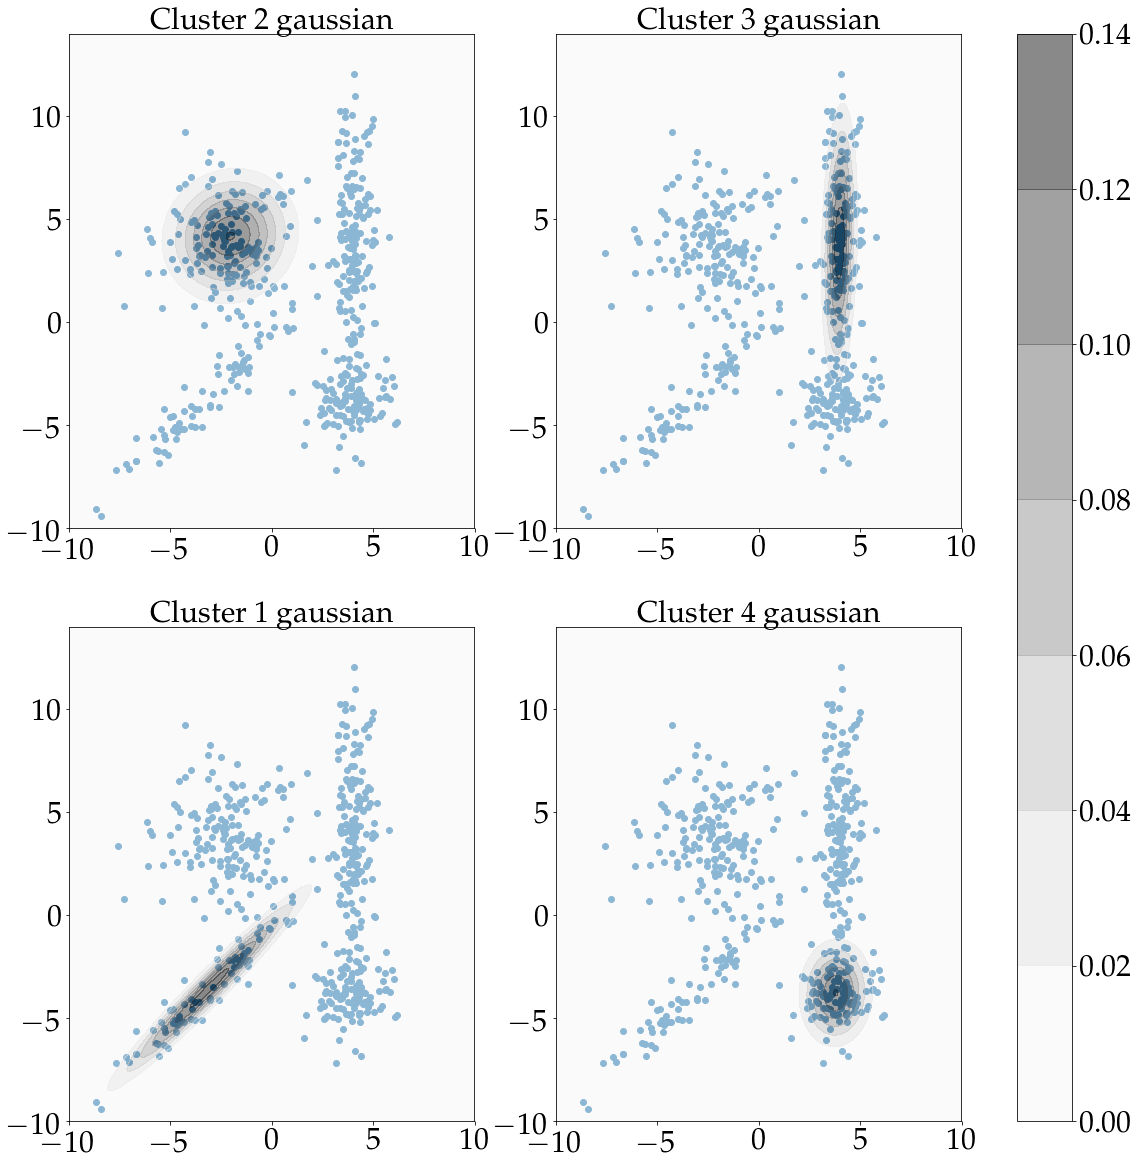

In [10]:
x, y = np.mgrid[-10:10:.01, -10:14:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
cmap = 'Greys'

f, ax = plt.subplots(2, 2, figsize = (20, 20));
ax[1][0].scatter(u_test[:, 0], u_test[:, 1])
im1 = ax[1][0].contourf(x, y, emission[0].pdf(pos), cmap = cmap, alpha = 0.5);
ax[1][0].set_title("Cluster 1 gaussian");
ax[0][0].scatter(u_test[:, 0], u_test[:, 1])
ax[0][0].contourf(x, y, emission[1].pdf(pos), cmap = cmap, alpha = 0.5);
ax[0][0].set_title("Cluster 2 gaussian");
ax[0][1].scatter(u_test[:, 0], u_test[:, 1])
ax[0][1].contourf(x, y, emission[2].pdf(pos), cmap = cmap, alpha = 0.5);
ax[0][1].set_title("Cluster 3 gaussian");
ax[1][1].scatter(u_test[:, 0], u_test[:, 1])
im4 = ax[1][1].contourf(x, y, emission[3].pdf(pos), cmap = cmap, alpha = 0.5);
ax[1][1].set_title("Cluster 4 gaussian");
plt.colorbar(im4, ax = ax);

# HMM - implementation

In [13]:
HMM(np.zeros((10, 1)), 5, {0: "test", 1: "test", 2: "test", 3: "test", 4: "test"})

We consider the following HMM model : the chain (q t ) has K = 4 possible states,
with an initial probability distribution π ∈ R 4 and a probability transition matrix
A ∈ R 4×4 , and conditionally on the current states we have observations obtained from
Gaussian emission probabilities u t |q t = i ∼ N (μ i , Σ i ).

## 1. $\alpha$ and $\beta$ recursion
Implement the recursions α et β seen in class (and that can be found in the
polycopié as well) to compute p(q t |u 1 , . . . , u T ) and p(q t , q t+1 |u 1 , . . . , u T ).

In [11]:
pi = [1/4] * 4
print ("pi\n", pi)

A = np.zeros((4,4)) + 1/6
np.fill_diagonal(A, 1/2)
print ("A\n", A)

pi
 [0.25, 0.25, 0.25, 0.25]
A
 [[ 0.5      0.16667  0.16667  0.16667]
 [ 0.16667  0.5      0.16667  0.16667]
 [ 0.16667  0.16667  0.5      0.16667]
 [ 0.16667  0.16667  0.16667  0.5    ]]


## 2. $p(q_t \mid u_1, \dots, u_T)$ using $\alpha$ and $\beta$ recursion
Using the same parameters for the means and covariance matrix of the 4 Gaus-
sians as the ones obtained in the previous homework, taking a uniform initial
probability distribution $\pi$, and setting A to be the matrix with diagonal coef-
ficients $A_{ii} = \frac{1}{2}$ and off-diagonal coefficients $A_{ij} = \frac{1}{6} \forall (i, j) \in [1, \dots , 4]^2$ , compute $\alpha_t$ and $\beta_t$ for all t on the test data (_EMGaussienne.test_ file) and
compute $p(q_t \mid u_1, \dots, u_T)$. Finally, represent $p(q_t \mid u_1, \dots, u_T)$ for each of the 4
states as a function of time for the 100 first datapoints in the file. Note that only the 100 first points should be plotted by that filtering should be done with all the data (i.e. T = 500). This will be the same for the subsequent questions.

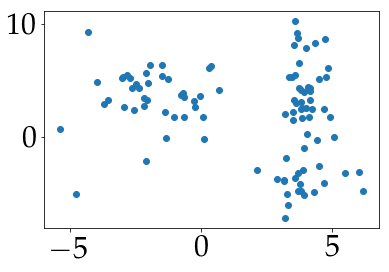

In [12]:
# First 100 points of the test dataset
first_100 = D["test"].as_matrix()[:100]
plt.scatter(first_100[:, 0], first_100[:, 1]);

In [40]:
hmm = HMM(u_test, 4, emission, A = A, pi = pi)
hmm._alpha_recursion(u_test, update = True)
hmm._alpha_norm_recursion(u_test, update = True)
hmm._beta_recursion(u_test, update = True)
smoothing = hmm._smoothing_all(check = False, update = True)

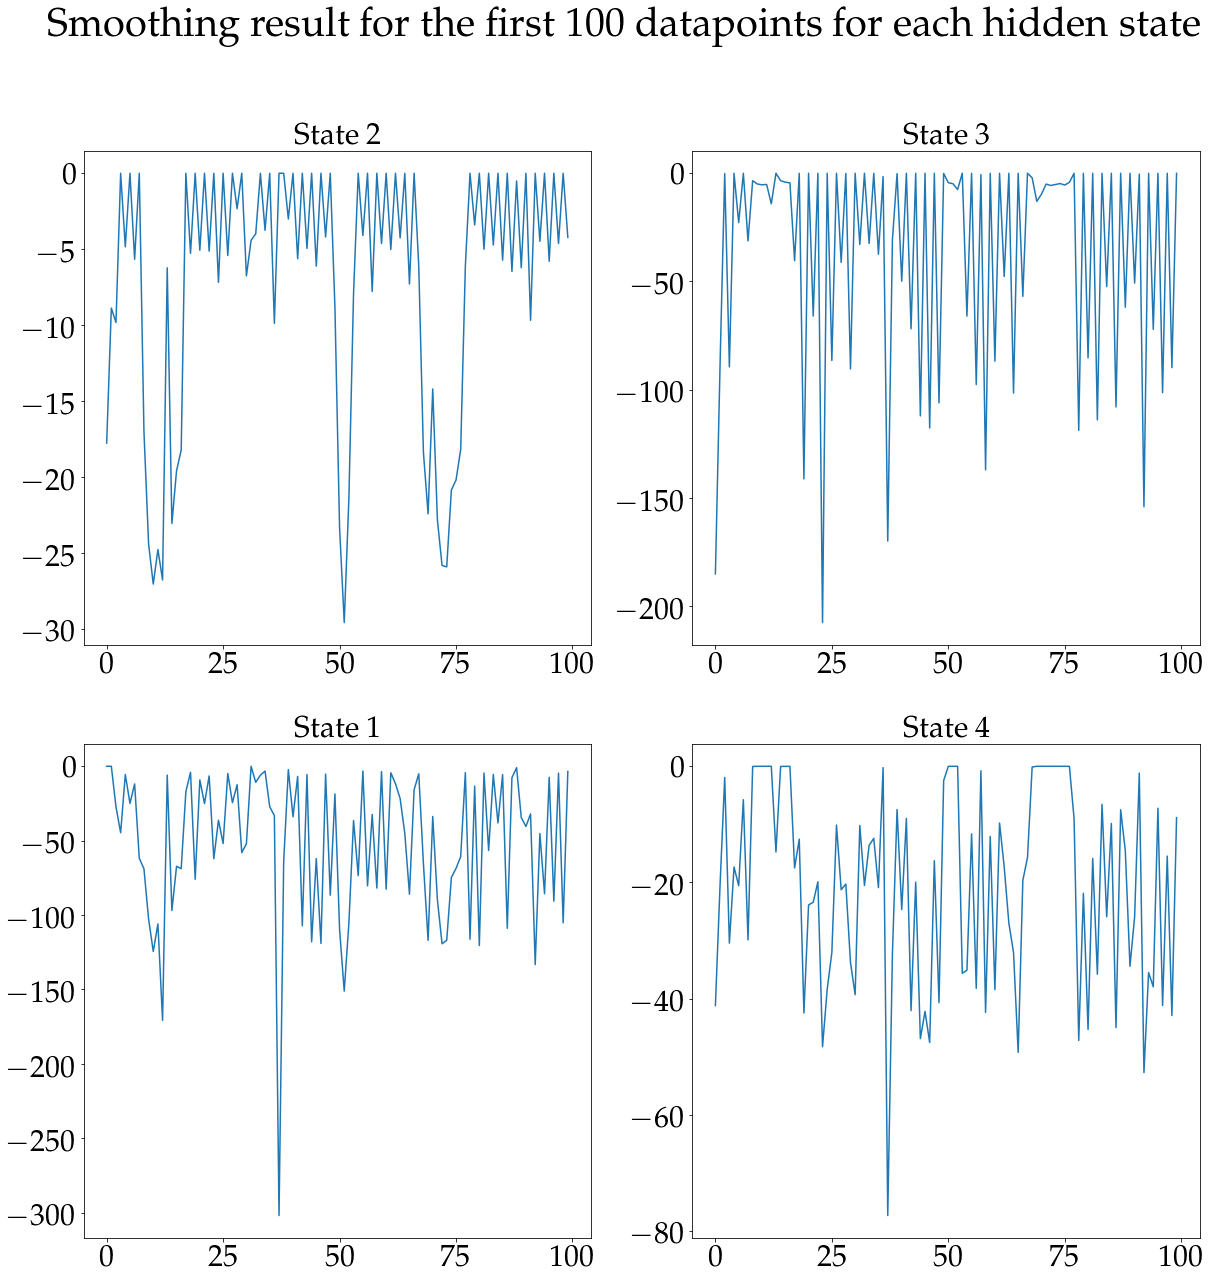

In [45]:
f, ax = plt.subplots(2, 2, figsize = (20, 20));
im1 = ax[1][0].plot(smoothing[0, :100]);
ax[1][0].set_title("State 1");
ax[0][0].plot(smoothing[1, :100]);
ax[0][0].set_title("State 2");
ax[0][1].plot(smoothing[2, :100]);
ax[0][1].set_title("State 3");
im4 = ax[1][1].plot(smoothing[3, :100]);
ax[1][1].set_title("State 4");
f.suptitle("Smoothing result for the first 100 datapoints for each hidden state", size = 40);

In [46]:
hmm.O[0].mean

array([-3.0599, -3.5326])

In [367]:
COLS

['red', 'blue', 'green', 'orange', 'black', 'cyan']

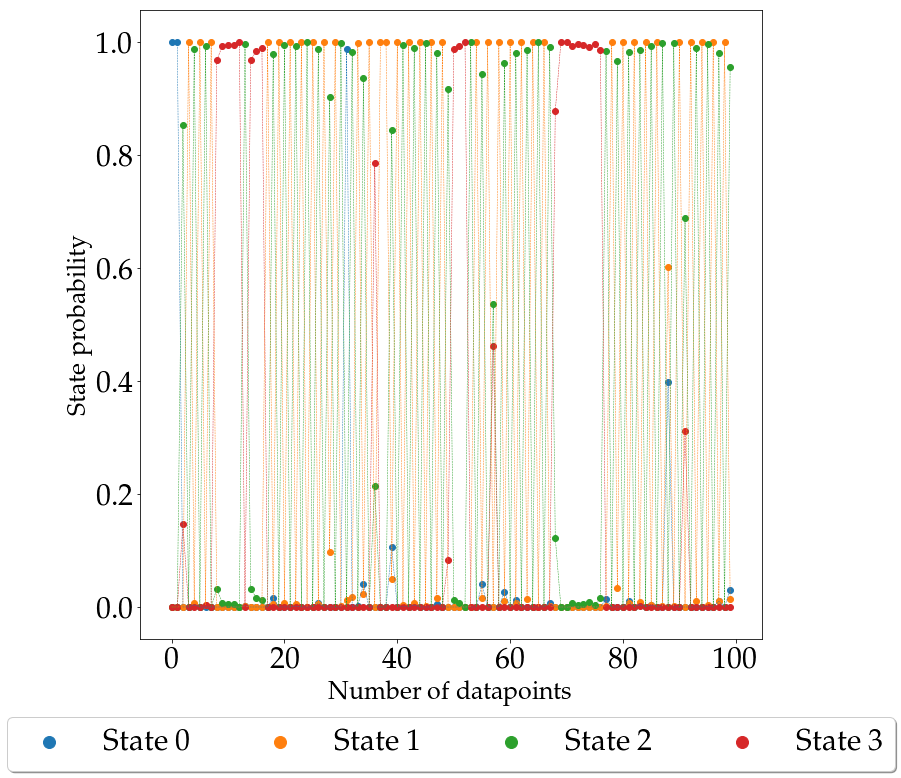

In [147]:
f, ax = plt.subplots(1, figsize = (10, 10))
for i in range(4):
    plt.scatter(np.arange(100), np.exp(smoothing[i, :100]), label = "State {}".format(i))
    plt.plot(np.arange(100), np.exp(smoothing[i, :100]), '--', lw = 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
            fancybox=True, shadow=True, ncol=4, fontsize = 30,
            markerscale = 2);
plt.xlabel("Number of datapoints", fontsize = 25);
plt.ylabel("State probability", fontsize = 25);
plt.title("smoothing result for the first 100 datapoints", fontsize = 30)
f.tight_layout();
# f.savefig("images/2_smoothing.eps", dpi = 300, bbox_inches='tight', pad_inches=1)

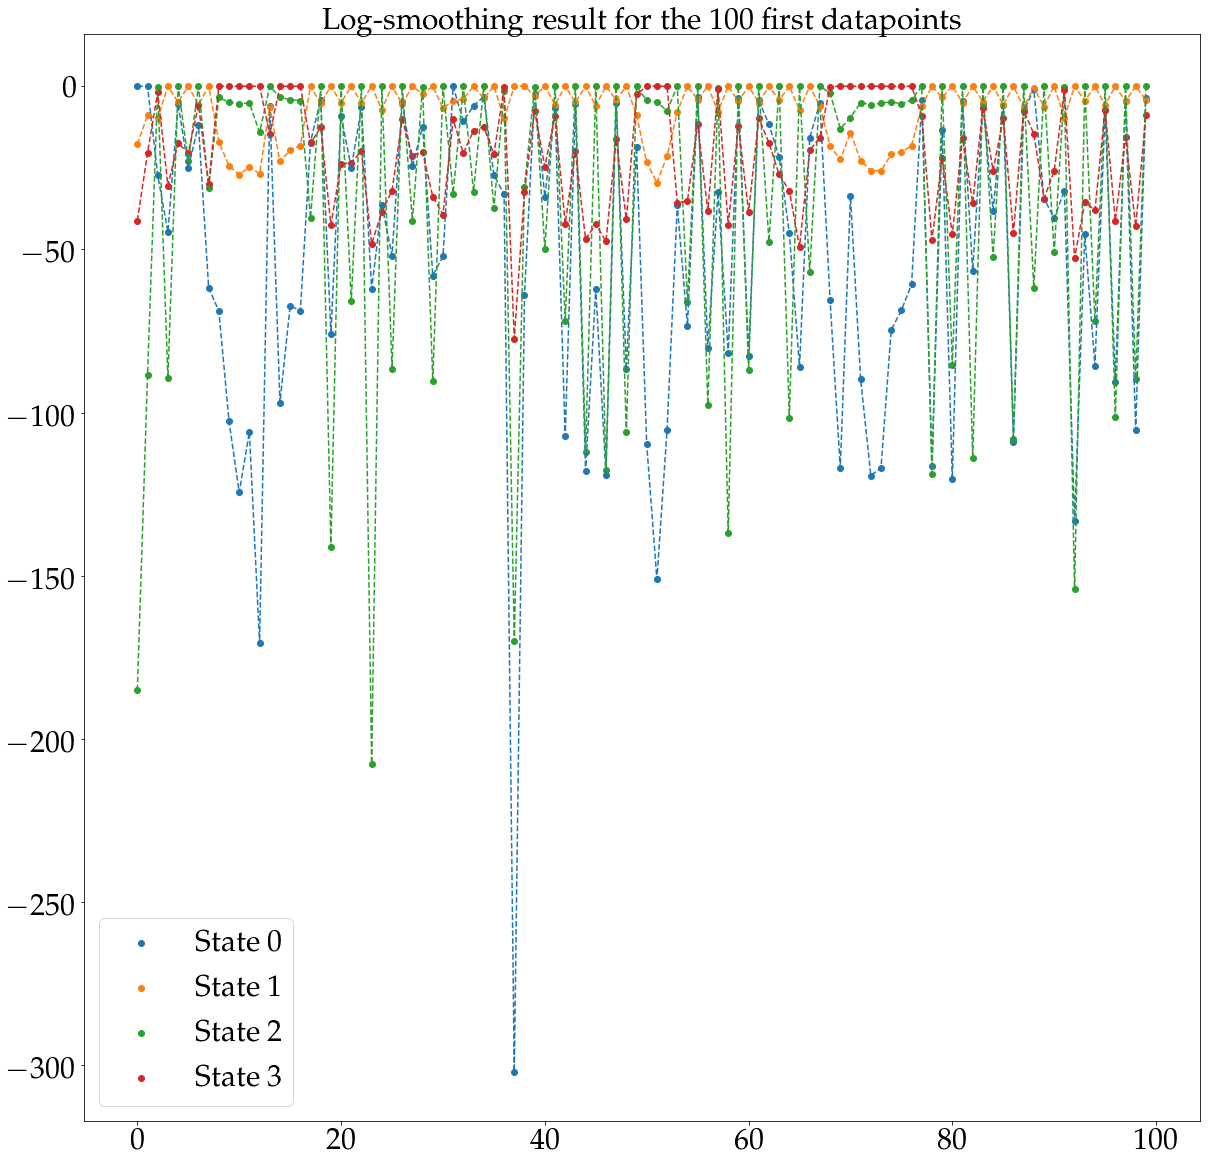

In [55]:
f, ax = plt.subplots(1, figsize = (20, 20))
for i in range(4):
    plt.scatter(np.arange(100), smoothing[i, :100], label = "State {}".format(i))
    plt.plot(np.arange(100), smoothing[i, :100], '--')
plt.title("Log-smoothing result for the 100 first datapoints")
plt.legend();

## 3. Derive the estimation equations of the EM algorithm.

\begin{equation}
\begin{aligned}
\gamma_1^{i, (s+1)} := p(q_1^i = 1 \mid u, \theta^{(s)})\\
\xi^{ij, (s+1)}_{t-1, t} := p\left(q_{t-1}^i = 1, q_t^j = 1 \mid u, \theta^{(s)}\right)\\
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\widehat{\pi_{i}}^{(s + 1)} &= \gamma_1^{i, (s+1)}\\
	\widehat{A}_{ij}^{(s+1)} &= \frac{\sum_{t=2}^T \xi^{ij, (s+1)}_{t-1, t}}{\sum_{t=2}^T \gamma^{i, (s+1)}_{t-1}} \\
\widehat{\mu_k}^{(s+1)}    & = \frac{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)} u_t}{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)}} \quad \forall k \in [\![1;M]\!]                                                         \\
		\widehat{\Sigma_k}^{(s+1)} & = \frac{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)}\left(u_t - \mu_k\right)\left(u_t - \mu_k\right)^{\intercal}}{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)}} \quad \forall k \in [\![1;M]\!] 
\end{aligned}
\end{equation}

## 4. Derive the estimation equations of the EM algorithm.
Implement the EM algorithm to learn the parameters of the model ($\pi$, $A$, $\mu_k$, $\Sigma_k$, $\forall k = 1 ,\dots, 4)$. The means and covariances could be initialized with the ones ob-
tained in the previous homework. Learn the model from the training data
in“EMGaussienne.dat”.

In [59]:
hmm = HMM(u_train, 4, emission, A = A, pi = pi)
hmm._alpha_recursion(u_train, update = True)
hmm._alpha_norm_recursion(u_train, update = True)
hmm._gamma_recursion(u_train, update = True)
hmm._beta_recursion(u_train, update = True)
hmm._xi_recursion(u_train, update = True)

params = hmm._EM(u_train)

Incomplete likelihood in training: -2.2993e+03
Incomplete likelihood in training: -1.9131e+03
Incomplete likelihood in training: -1.8988e+03
Incomplete likelihood in training: -1.8971e+03
Incomplete likelihood in training: -1.8968e+03
Incomplete likelihood in training: -1.8968e+03


In [60]:
# Verification of the validity of xis (each squared matrix has to sum to 1)
(np.round(hmm.xis.sum(axis = (1,2)), 3) == 1).all()

True

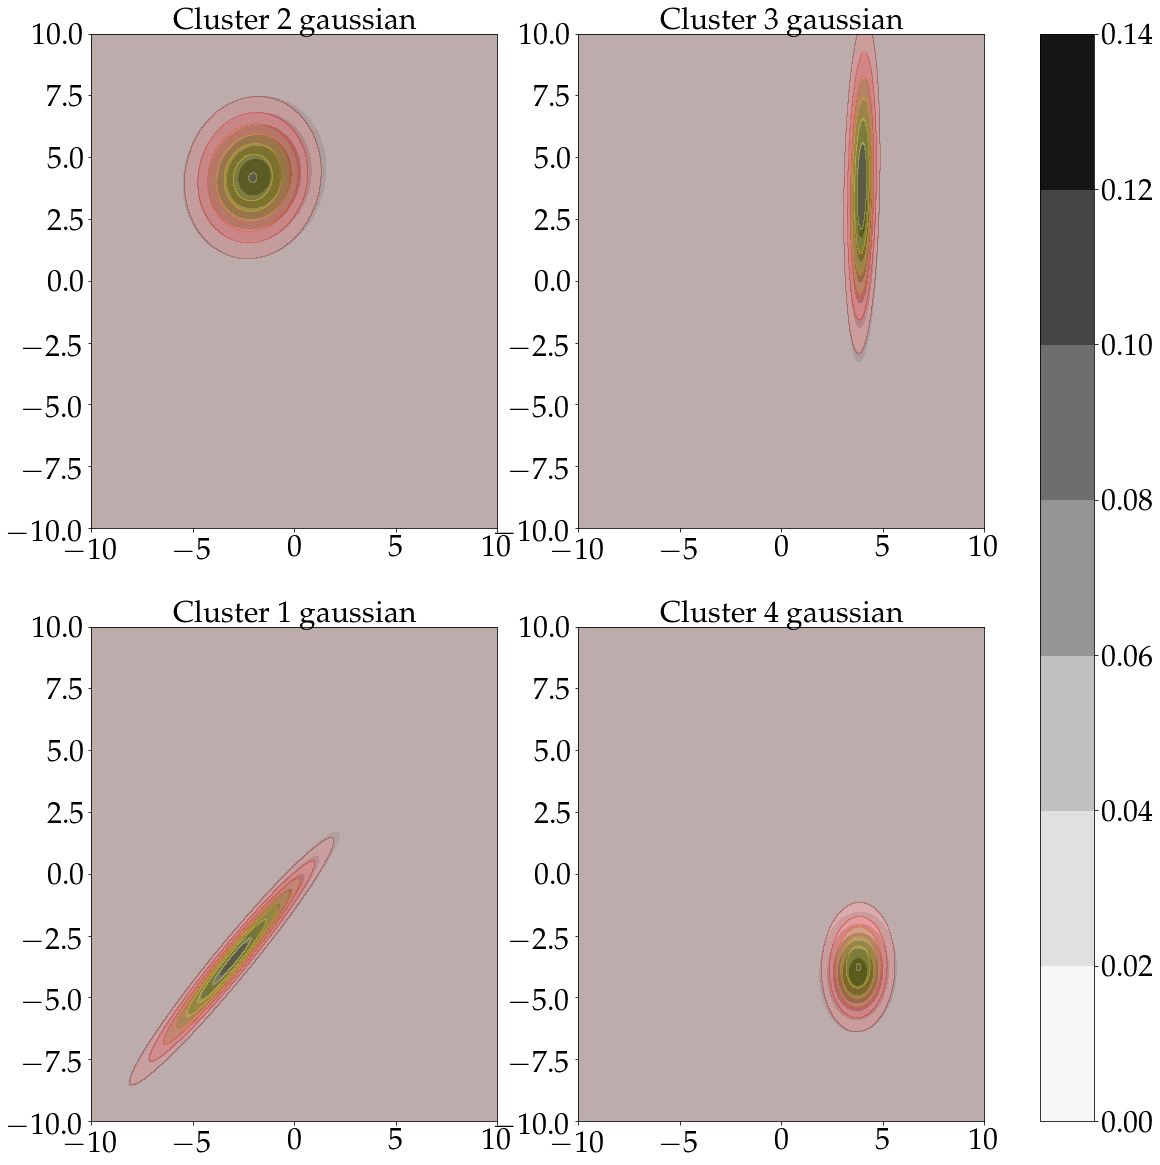

In [61]:
O = np.array([multivariate_normal(params["mu"][key], params["sigma"][key])
           for key in range(params["mu"].shape[0])])
x, y = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
cmap = 'Greys'
cmap2 = "hot"

f, ax = plt.subplots(2, 2, figsize = (20, 20));
im1 = ax[1][0].contourf(x, y, O[0].pdf(pos), cmap = cmap);
ax[1][0].contourf(x, y, emission[0].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[1][0].set_title("Cluster 1 gaussian");
ax[0][0].contourf(x, y, O[1].pdf(pos), cmap = cmap);
ax[0][0].contourf(x, y, emission[1].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[0][0].set_title("Cluster 2 gaussian");
ax[0][1].contourf(x, y, O[2].pdf(pos), cmap = cmap);
ax[0][1].contourf(x, y, emission[2].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[0][1].set_title("Cluster 3 gaussian");
im4 = ax[1][1].contourf(x, y, O[3].pdf(pos), cmap = cmap);
ax[1][1].contourf(x, y, emission[3].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[1][1].set_title("Cluster 4 gaussian");
plt.colorbar(im4, ax = ax);

### Learn model on train dataset:
EM initialized with parameters obtained from gaussian mixture

In [84]:
K = 4
hmm = HMM(D["data"].as_matrix(), 4, emission, A = A, pi = pi)
params = hmm._EM(u_train, u_test)

Incomplete likelihood: -2.2993e+03 in train || -2.4237e+03 in test
Incomplete likelihood: -1.9131e+03 in train || -1.9785e+03 in test
Incomplete likelihood: -1.8988e+03 in train || -1.9611e+03 in test
Incomplete likelihood: -1.8971e+03 in train || -1.9574e+03 in test
Incomplete likelihood: -1.8968e+03 in train || -1.9561e+03 in test
Incomplete likelihood: -1.8968e+03 in train || -1.9555e+03 in test


In [64]:
params

{'mu': array([[-2.96884, -3.44596],
        [-1.95059,  4.1938 ],
        [ 3.99441,  3.63574],
        [ 3.78933, -3.9734 ]]), 'sigma': array([[[  6.80928,   6.58546],
         [  6.58546,   6.68652]],
 
        [[  3.28135,   0.30347],
         [  0.30347,   2.83084]],
 
        [[  0.1976 ,   0.25902],
         [  0.25902,  12.33517]],
 
        [[  0.94397,   0.06161],
         [  0.06161,   1.55783]]])}

In [65]:
GM_params_general

{'likelihood_test': -2.40917e+03,
 'likelihood_train': -2.32773e+03,
 'mu': array([[-3.0599 , -3.5326 ],
        [-2.03408,  4.17288],
        [ 3.98082,  3.83154],
        [ 3.79965, -3.77777]]),
 'pi': array([[ 0.30566],
        [ 0.25157],
        [ 0.25742],
        [ 0.18535]]),
 'sigma': array([[[  6.25185,   6.05995],
         [  6.05995,   6.19158]],
 
        [[  2.90574,   0.20778],
         [  0.20778,   2.75669]],
 
        [[  0.20862,   0.27747],
         [  0.27747,  11.97735]],
 
        [[  0.91297,   0.05585],
         [  0.05585,   1.90662]]])}

## 5. Plot the log-likelihood on the train data “EMGaussienne.dat” and on the test data “EMGaussienne.test” as a function of the iterations of the algorithm.
Comment.

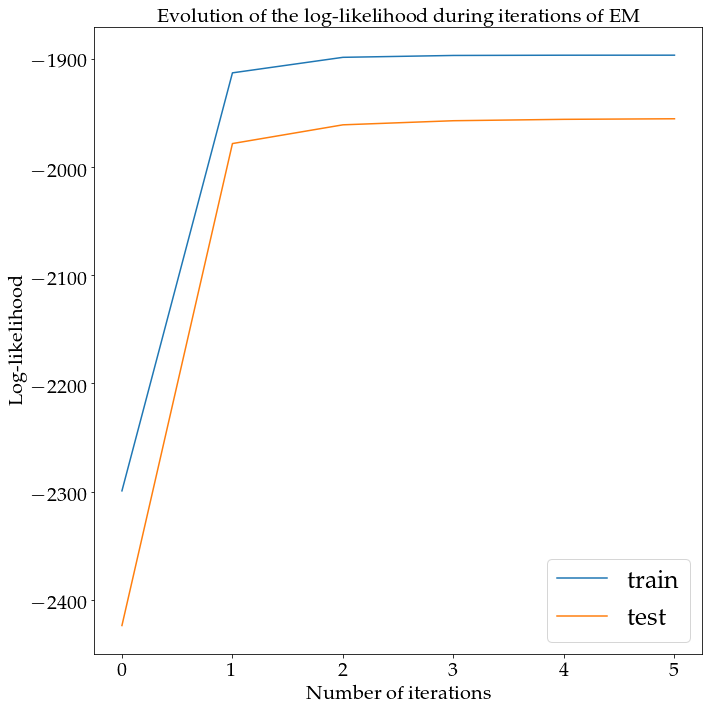

In [72]:
plt.figure(figsize=(10,10))
plt.plot(hmm.likelihood_train, label = "train");
plt.plot(hmm.likelihood_test, label = "test");
plt.xticks(size = 20);
plt.yticks(size = 20);
plt.xlabel("Number of iterations", fontsize = 20);
plt.ylabel("Log-likelihood", fontsize = 20);
plt.legend(fontsize = 25, loc = 'lower right');
plt.title("Evolution of the log-likelihood during iterations of EM", fontsize = 20)
plt.tight_layout()
# plt.savefig("images/5_em_llh.eps", dpi = 300, bbox_inches='tight', pad_inches=1)

## 6. Return in a table the values of the log-likelihoods of the Gaussian mixture models and of the HMM on the train and on the test data.
Compare these values. Does it make sense to make this comparison ? Conclude. Compare these
log-likelihoods as well with the log-likelihoods obtained for the different models
in the previous homework.

|model \ data | train | test |
|------|------------------|-----|
|GM isotropic | -2.6396 | -2.6146|
|GM general | -2.3277| -2.4092|
|HMM| -1.8968| -1.9555|

### 7. Provide a description and pseudo-code for the Viterbi decoding algorithm
(aka MAP inference algorithm or max-product algorithm) that estimates the most
likely sequence of states, i.e. $\arg \max_q p(q_1 , \dots, q_T \mid u_1 , . . . , u_T)$

cf report

### 8. Implement Viterbi decoding.
For the set of parameters learned with the EM algorithm, compute the most likely sequence of states with the Viterbi algo-
rithm and represent the data in 2D with the cluster centers and with markers
of different colors for the datapoints belonging to different classes.

In [154]:
u_max = 100
q_star, logp = hmm._viterbi(u_test[:u_max], hmm.pi, hmm.A, hmm.O)

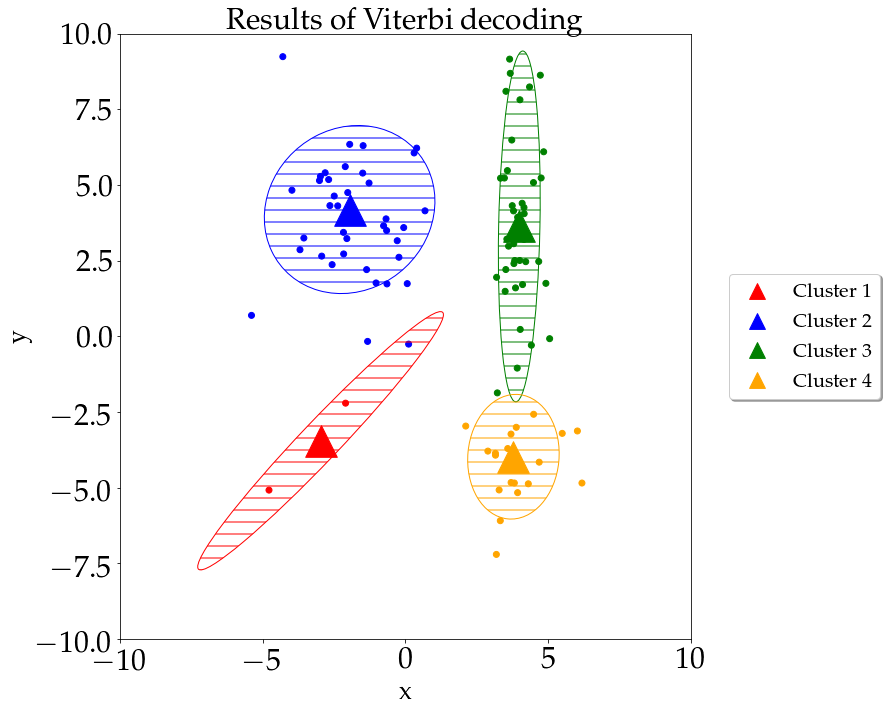

In [156]:
plt.figure(figsize = (10,10))
for i in range(hmm.M):
    plt.scatter(hmm.O[i].mean[0],
                hmm.O[i].mean[1],
                c = COLS[i],
                marker = "^",
                s = 1000,
                label = "Cluster {}".format(i + 1))
    plot_cov_ellipse(hmm.O[i].cov,
                     hmm.O[i].mean.T,
                     nstd = 1.65,
                     fill = False,
                     hatch = '-',
                     color = COLS[i])
plt.scatter(u_test[:u_max, 0], u_test[:u_max, 1], color = np.array(COLS)[q_star]);
plt.xlim(-10,10);
plt.ylim(-10,10);
plt.title("Results of Viterbi decoding", fontsize = 30)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5),
           fancybox=True, shadow=True, fontsize = 20,
            markerscale = 0.5);
plt.xlabel("x", fontsize = 25);
plt.ylabel("y", fontsize = 25);
# plt.savefig("images/8_viterbi_decoding.eps", dpi = 300, bbox_inches='tight', pad_inches=1)
plt.tight_layout();

### 9. For the datapoints in the test file “EMGaussienne.test”, compute the marginal probability
$p(q_t \mid u_1 , \dots , u_T)$ for each point to be in state {1, 2, 3, 4} for the
parameters learned on the training set. For each state plot the probability of
being in that state as a function of time for the 100 first points (i.e., as a
function of the datapoint index in the file).